# Lab 9 - Differential Privacy

In this lab, we will explore Differential Privacy in Machine Learning Models.

Specifically, we will create a private Machine Learning Models using three different methods.  
Each method preserves a distinct aspect of privacy, which we will discuss in detail later.

1. **Output Perturbation** - Randomized Response 
2. **Perturbation Data**  - Laplacian Noise
3. **Perturbation of the Objective Function** -  Differentially private Empirical Risk Minimization

### Materials for the Lab
1. Course slides  
2. [Christos' Book](https://github.com/olethrosdc/ml-society-science/blob/master/book.pdf)  
3. [Differential Privacy Tutorials](https://programming-dp.com/cover.html)  
4. [PyTorch Tutorials](https://programming-dp.com)

### Libraries
1. A privacy-focused library similar to scikit-learn: [Diffprivlib](https://diffprivlib.readthedocs.io/en/latest/)  
2. A library for implementing private PyTorch models: [Opacus](https://opacus.ai/)

## Motivation

Differential Privacy is a critical concept in modern machine learning.The primary goal of machine learning models is to learn useful patterns that generalize well, enabling accurate predictions and decisions on unseen data. As discussed in previous labs, deep learning models often contain millions of parameters, which can lead to overfitting due to the "memorization" of information within these parameters.

This memorization poses a significant risk: sensitive or private information from the training dataset can inadvertently be encoded into the model, potentially harming individual privacy.

Differential Privacy aims to address this issue by ensuring that models do not reveal specific details about individuals in the training data while still learning meaningful and generalizable patterns.

### Assumptions

The general assumption is that an adversary has access to the trained model, including its complete structure and the values of all parameters. Under these conditions, we must ensure that the adversary cannot extract sensitive information about individuals in the dataset. The most common privacy-related concerns include:

1. **Membership Inference Attacks**  
   - **Goal**: Determine if a specific individual's data was included in the training dataset.

2. **Reconstruction Attacks**  
   - **Goal**: Reconstruct sensitive features of individuals whose data contributed to the model.

For a more detailed overview of these and other related concerns, refer to this resource: [Understanding Privacy Risks](https://arxiv.org/pdf/2011.11819).

<img src="./img/attack.png" alt="Effect of Epsilon on Model Accuracy" width="600">

Paper: [Model inversion attacks that exploit confidence information and basic countermeasures](https://dl.acm.org/doi/pdf/10.1145/2810103.2813677)

Today, we will explore three different techniques to preserve the privacy of the training data using the Adult dataset as an example.

# A. Load Data
In will use the Adult data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from collections import OrderedDict

data_types = OrderedDict([
    ("age", "int"),
    ("workclass", "category"),
    ("final_weight", "int"),  # originally it was called fnlwgt
    ("education", "category"),
    ("education_num", "int"),
    ("marital_status", "category"),
    ("occupation", "category"),
    ("relationship", "category"),
    ("race", "category"),
    ("sex", "category"),
    ("capital_gain", "float"),  # required because of NaN values
    ("capital_loss", "int"),
    ("hours_per_week", "int"),
    ("native_country", "category"),
    ("income_class", "category"),
])
target_column = "income_class"

def read_dataset(path):
    return pd.read_csv(
        path,
        names=data_types,
        index_col=None,

        comment='|',  # test dataset has comment in it
        skipinitialspace=True,  # Skip spaces after delimiter
        na_values={
            'capital_gain': 99999,
            'workclass': '?',
            'native_country': '?',
            'occupation': '?',
        },
        dtype=data_types,
    )

def clean_dataset(data):
    # Test dataset has dot at the end, we remove it in order
    # to unify names between training and test datasets.
    data['income_class'] = data.income_class.str.rstrip('.').astype('category')
    
    # Remove final weight column since there is no use
    # for it during the classification.
    data = data.drop('final_weight', axis=1)
    
    # Duplicates might create biases during the analysis and
    # during prediction stage they might give over-optimistic
    # (or pessimistic) results.
    data = data.drop_duplicates()
    
    # Binary target variable (>50K == 1 and <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)
    
    # Categorical dataset
    categorical_features = data.select_dtypes('category').columns
    data[categorical_features] = data.select_dtypes('category').apply(lambda x: x.cat.codes)
    return data

In [6]:
# get and clean train dataset
TRAIN_DATA_FILE = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
train_data = train_data.dropna()
print("Train dataset shape:", train_data.shape)

# get and clean test dataset
TEST_DATA_FILE = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))
test_data = test_data.dropna()
print("Test dataset shape:", test_data.shape)

Train dataset shape: (28938, 14)
Test dataset shape: (15175, 14)


In [7]:
target_column = "income_class"
features = train_data.columns.difference([target_column]).tolist()

In [8]:
N=len(features)

# A. Train a simple model

scale features

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(train_data[features]),index=train_data.index,columns = features)
y_train = train_data[[target_column]]

X_test_scaled = pd.DataFrame(scaler.transform(test_data[features]),index=test_data.index ,columns = features) # note that here we just use the transform method!
y_test = test_data[[target_column]]

train model

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_scaled, y_train[target_column])

LogisticRegression()

evaluate

In [11]:
from sklearn.metrics import accuracy_score
predictions = model.predict(X_test_scaled[features])
accuracy = accuracy_score(y_true=test_data[target_column], y_pred=predictions)

In [12]:
accuracy

0.8214827018121911

# B. **Output Perturbation** - Randomized Response

A simple method is to apply randomized response to the output of the model. 
Note that in this method, we assume that the adversary does not have access to the parameters of the model, but can only query the model ones. An example is when we deploy a machine learning model through an API, and the adversary can request predictions on this data ones.

Randomized response flips the output of the model with some probability $ p $ for a binary response. 
If we want to ensure privacy with $ \epsilon $-differential privacy guarantees, we need to set the probability of flipping as:

$$
p = \frac{1}{e^\epsilon + 1}
$$

In [13]:
epsilon = 1

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(train_data[features]),index=train_data.index,columns = features)
y_train = train_data[[target_column]]
X_test_scaled = pd.DataFrame(scaler.transform(test_data[features]),index=test_data.index ,columns = features) # note that here we just use the transform method!
y_test = test_data[[target_column]]

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_scaled, y_train[target_column])

LogisticRegression()

In [16]:
from sklearn.metrics import accuracy_score
predictions = model.predict(X_test_scaled[features])

In [17]:
predictions

array([0, 0, 0, ..., 0, 1, 1])

In [19]:
np.random.rand() < p then we flip the prediction 

0.1451952822402568

In [28]:
def randomised_response(prediction, epsilon):
    # step 1. define the flip propability
    p = 1 / (np.exp(epsilon) + 1)
    
    # step 2. flip predictions
    # hint: in order to flip the prediction we can generate a random number [0,1] and if is less than p we can flip
    # otherwise we keep the true prediction
    flip_mask = np.random.rand(prediction.shape[0]) < p
    noisy_predictions = prediction.copy()
    noisy_predictions[flip_mask] = 1 - noisy_predictions[flip_mask]
    
    return noisy_predictions

In [29]:
noisy_predictions = randomised_response(predictions, epsilon)

In [30]:
accuracyRR = accuracy_score(y_true=test_data[target_column], y_pred=noisy_predictions)
accuracyRR

0.6540362438220758

### Note on SGD with Output Perturbation

Output perturbation preserves privacy only in scenarios where the adversary can query the model.  
However, the concept of output perturbation can also be applied during model training.

For instance, during training, we can generate predictions, add noise to them, 
and then compute the loss of the model based on these noisy predictions. 
The model is then optimized using SGD.

###### This procedure ensures privacy even when the adversary has access to the parameters of the model so they can query the model more than ones.

# C. Data Perturbation

On other simple technique to preserve privacy is to add noise to the dataset before training. In this approach, privacy is preserved thanks to the post-processing theorem, which ensures that after applying any differential privacy noise to the results, privacy is maintained for each subsequent maniplulation of the data.

#### Theorem 2.6.2 [Post-processing].
Let mechanism $ \pi(a \mid x) $ be $ \epsilon $-DP. Applying any transformation $ f : A \to Y $ to the output of the mechanism to obtain $ y = f(a) $, results in another $ \epsilon $-DP mechanism.


We will implement Laplacian noise, which adds Laplacian noise to the dataset.  

## Laplacian Mechanism

To achieve differential privacy, we add noise to the dataset $D$, where the noise is drawn from a **Laplace distribution**.

$$
\hat{D} = D + \text{Lap}(0, b)
$$

where $ \hat{D} $ is the noisy dataset, and $ \text{Lap}(0, b) $ is Laplacian noise with mean 0 and scale $ b $.

#### Noise Scale $ b $:

The scale $ b $ of the Laplace distribution is related to the **sensitivity** $ \Delta $ of the function and the privacy budget $ \epsilon $:

$$
b = \frac{\Delta }{\epsilon}
$$

We will implement the Laplacian mechanism on the dataset.

###### Step 1:  Calculate $\epsilon$ for each individual mechanism/feature.
[Theorem 2.6.1 book]
For any $ \epsilon > 0 $,  if each mechanism is $ \epsilon_i $-DP, the composed mechanism is $ \sum_{i=1}^T \epsilon_i $-DP.

So for each feature we want to use $\epsilon_i =  \epsilon / N$


###### Step 2:  Calculate the sensitivity of each feature.
When we add noise in the dataset the sensitivty is the difference between the maximum and minimum value.
######  Step 3:  Add Laplacian noise to each feature based on its sensitivity and privacy budget.

In [42]:
def add_laplacian_noise(epsilon, N, data):
    # step 1. define epsilon for each feature
    feature_epsilon = epsilon / N
    
    # step 2. caluclate sensitivity
    sensitivity = train_data.describe().loc["max"] - train_data.describe().loc["min"]
    
    # step 3. add noise for each feature
    noisy_data = data.copy()
    for feature in data[features].columns:
        sensitivity_feature = sensitivity[feature]
        scale = sensitivity_feature/feature_epsilon
        noise = np.random.laplace(loc=0, scale=scale, size = data.shape[0])
        noisy_data[feature] = noisy_data[feature] + noise
    return noisy_data

In [45]:
noisy_data = add_laplacian_noise(epsilon,N, train_data)

preprossesing

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(noisy_data[features]),index=noisy_data.index,columns = features)
y_train = train_data[[target_column]]
X_test_scaled = pd.DataFrame(scaler.transform(test_data[features]),index=test_data.index ,columns = features) # note that here we just use the transform method!
y_test = test_data[[target_column]]

train

In [47]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_scaled, y_train[target_column])

LogisticRegression()

evaluate

In [48]:
from sklearn.metrics import accuracy_score
predictions = model.predict(X_test_scaled[features])
accuracy_data_noise = accuracy_score(y_true=test_data[target_column], y_pred=predictions)

In [49]:
accuracy_data_noise

0.7646787479406919

# D. Differentially private empirical risk minimization

Differentially Private Empirical Risk Minimization is a framework that allows you to learn models from data while ensuring the privacy of individuals in the dataset. By adding noise to the loss function or optimization process, it ensures that the learned model does not reveal too much information about any single data point, providing differential privacy guarantees. The challenge lies in balancing the trade-off between privacy and the accuracy of the learned model.

$$ \hat{L} = Loss + noise $$

The paper of the work can be found [here](https://jmlr.org/papers/volume12/chaudhuri11a/chaudhuri11a.pdf) 

We will use model from the following library: [Diffprivlib](https://diffprivlib.readthedocs.io/en/latest/)  

To train a neural network with DP and pytorch you can use [Opacus library](https://opacus.ai/)

In [57]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(train_data[features]),index=train_data.index,columns = features)
y_train = train_data[[target_column]]
X_test_scaled = pd.DataFrame(scaler.transform(test_data[features]),index=test_data.index ,columns = features) # note that here we just use the transform method!
y_test = test_data[[target_column]]

In [58]:
from diffprivlib.models import LogisticRegression as LogisticRegressionDP
dp_model = LogisticRegressionDP(epsilon=epsilon)
dp_model.fit(X_train_scaled, y_train[target_column])

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


LogisticRegression(accountant=BudgetAccountant(spent_budget=[(1, 0), (1, 0)]),
                   data_norm=15.681533341970946, epsilon=1)

In [59]:
from sklearn.metrics import accuracy_score
predictions = dp_model.predict(X_test_scaled[features])
accuracy_DP_ERM = accuracy_score(y_true=test_data[target_column], y_pred=predictions)

In [60]:
accuracy_DP_ERM

0.8180560131795717

# Compare models

In [61]:
results= {
            "Simple Model": accuracy,
            "private ERM":accuracy_DP_ERM,
            "data noise": accuracy_data_noise,
            "RR":accuracyRR
            }

In [62]:
results

{'Simple Model': 0.8214827018121911,
 'private ERM': 0.8180560131795717,
 'data noise': 0.7646787479406919,
 'RR': 0.6540362438220758}

<AxesSubplot: >

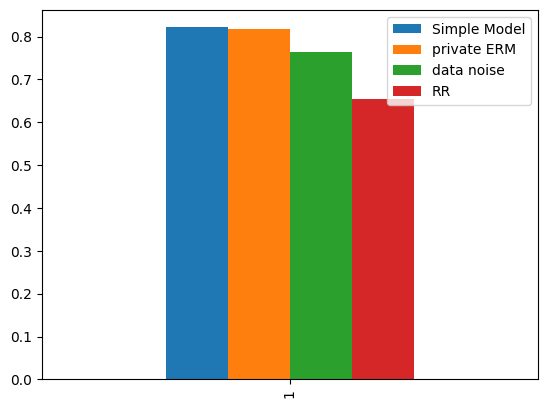

In [63]:
pd.DataFrame(results,index=[1]).plot(kind="bar")

### Effect of Epsilon

As with fairness, there is a trade-off between privacy and accuracy. 

In this section, we examine the effect of epsilon on the model's accuracy. Specifically, for each value of epsilon defined below, we will train 50 models to calculate the average accuracy and the standard deviation of the performance metric. The results will then be plotted to visualize the differences.

In [64]:
epsilons = np.logspace(-2, 2, 20)

In [65]:
epsilons

array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])

In [66]:
!pip install diffprivlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 KB 799.6 kB/s eta 0:00:00a 0:00:01
You should consider upgrading via the '/Users/andreasathanasopoulos/Phd/projects/bayesian_fairness/envs/bayesian-fairness/bin/python3.9 -m pip install --upgrade pip' command.


In [71]:
from diffprivlib.models import GaussianNB as private_GaussianNB

# for different epsilon
acc_mean = []
acc_std = []
for e in epsilons:
    
    # train the model 50 times
    acc_list = []
    for _ in range(50):
        # train DP model with Difflib
        dp_model = LogisticRegressionDP(epsilon=e)
        dp_model.fit(X_train_scaled, y_train[target_column])
        # evaluate on testset
        predictions = dp_model.predict(X_test_scaled[features])
        acc = accuracy_score(y_true=test_data[target_column], y_pred=predictions)
        acc_list += [acc]
        
    # save mean/std for the model
    acc_mean += [np.mean(acc_list)]
    acc_std += [np.std(acc_list)]

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasathanasopoulos/Phd/projects/env/ml-society/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:233: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/andreasat

Text(0, 0.5, 'accuracy')

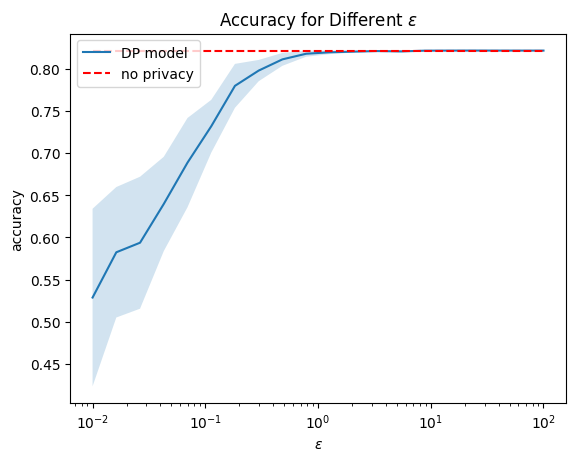

In [72]:
plt.semilogx(epsilons, acc_mean, label="DP model")
plt.fill_between(epsilons, 
                 np.array(acc_mean) - np.array(acc_std),
                 np.array(acc_mean) + np.array(acc_std),
                 alpha=0.2)
plt.hlines(accuracy, 0.01, 100, linestyles = "--",color="red", label="no privacy")
plt.legend()
plt.title("Accuracy for Different $\epsilon$")
plt.xlabel("$\epsilon$")
plt.ylabel("accuracy")

In [73]:
accuracy

0.8214827018121911